Installation et import des bibliothéques

In [1]:
!pip install --break-system-packages gensim nltk


Defaulting to user installation because normal site-packages is not writeable


In [2]:

import pandas as pd
import re
import spacy
from time import time
import nltk
from nltk.data import find
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [3]:
import sys
print(sys.executable)

/home/lydia/Desktop/tuto word_to_vec/.venv/bin/python


Téléchargement des ressources nltk

In [4]:
import nltk
nltk.download('punkt')
nltk.download('word2vec_sample')

[nltk_data] Downloading package punkt to /home/lydia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package word2vec_sample to
[nltk_data]     /home/lydia/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


True

Chargement des données

In [5]:
import pandas as pd
# Charge le fichier nécessaire (adapte le chemin si besoin)
df = pd.read_csv("simpsons_script_lines.csv",low_memory=False)

# Garde uniquement les colonnes utiles
df = df[["raw_character_text", "spoken_words"]]

# Supprime les lignes vides
df.dropna(inplace=True)

# Affiche un aperçu
df.head()


,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [6]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [7]:

import spacy


# Utilise le modèle léger de spaCy sans le parser ni la reconnaissance d'entités
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])



Fonction de nettoyage linguistique

In [8]:
def cleaning(doc):
    # Lemmatisation + suppression des stopwords
    txt = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(txt) if len(txt) > 2 else None


In [9]:
import re

brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df["spoken_words"])
brief_cleaning = list(brief_cleaning)  # Important !


Vérifier la sortie

In [10]:
print(len(brief_cleaning))
print(brief_cleaning[:5])


132110
["no actually it was a little of both sometimes when a disease is in all the magazines and all the news shows it's only natural that you think you have it ", "where's mr bergstrom ", "i don't know although i'd sure like to talk to him he didn't touch my lesson plan what did he teach you ", 'that life is worth living ', "the polls will be open from now until the end of recess now just in case any of you have decided to put any thought into this we'll have our final statements martin "]


Découpage en lots de taille fixe

In [15]:
from time import time

t = time()

# Traitement par lot avec n_process=1 (équivalent à l’ancien n_threads)
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=1)]

print("✅ Nettoyage terminé en", round((time() - t) / 60, 2), "minutes")



✅ Nettoyage terminé en 0.93 minutes


Application du nettoyage  par lot pour éviter le crash

Mettre le résultat dans un dataframe

In [16]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape


(86207, 1)

BIGRAMS

In [24]:
from gensim.models.phrases import Phrases, Phraser

In [28]:
sent = [row.split() for row in df_clean['clean']]  # Tokenisation simple
phrases = Phrases(sent, min_count=5, threshold=10)
bigram = Phraser(phrases)


Appliquer le modèle

In [31]:
sentences = bigram[sent]

Mots plus fréquents

In [34]:
print(list(sentences)[:5])


Exception ignored in: <function tqdm.__del__ at 0x7fa120a9fa60>
Traceback (most recent call last):
  File "/home/lydia/Desktop/tuto word_to_vec/.venv/lib/python3.11/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/lydia/Desktop/tuto word_to_vec/.venv/lib/python3.11/site-packages/tqdm/notebook.py", line 282, in close
    self.disp(bar_style='success', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


[['actually', 'little', 'disease', 'magazine', 'news', 'show', 'natural', 'think'], ['know', 'sure', 'like', 'talk', 'touch', 'lesson', 'plan', 'teach'], ['life', 'worth', 'live'], ['poll', 'open', 'end', 'recess', 'case', 'decide', 'thought', 'final', 'statement', 'martin'], ['victory', 'party', 'slide']]


Calculer les mots uniques

In [35]:
from collections import defaultdict

# Dictionnaire pour stocker la fréquence de chaque mot
word_freq = defaultdict(int)

# Remplir le dictionnaire avec les fréquences
for sent in sentences:
    for word in sent:
        word_freq[word] += 1

# Affichage du nombre de mots uniques
print("Nombre total de mots uniques :", len(word_freq))


Nombre total de mots uniques : 31032


Afficher les mots les plus fréquents

In [36]:
# Affichage des 10 mots les plus fréquents
sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10]


[('oh', 6456),
 ('like', 5569),
 ('know', 4837),
 ('get', 4207),
 ('think', 3607),
 ('hey', 3595),
 ('come', 3591),
 ('right', 3425),
 ('look', 3361),
 ('want', 3189)]

Entraînement du modèle Word2vec

Implementation Gensim Word2vec

In [37]:
import multiprocessing

from gensim.models import Word2Vec

Conter le nombre de cores in a computer


In [39]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

Entraîner le modèle

In [40]:
# Entraîner le modèle Word2Vec
w2v_model = Word2Vec(
    sentences=sentences,      # Les phrases tokenisées avec bigrammes
    vector_size=100,          # Taille des vecteurs de mots
    window=5,                 # Fenêtre de contexte
    min_count=5,              # Fréquence minimale pour considérer un mot
    workers=cores - 1         # Nombre de threads parallèles
)

print("✅ Entraînement terminé.")

✅ Entraînement terminé.


Building the Vocabulary Table

In [41]:
from time import time

t = time()

# Construction du vocabulaire à partir des phrases
w2v_model.build_vocab(sentences, progress_per=10000)

print("⏱️ Temps de construction du vocabulaire :", round((time() - t) / 60, 2), "minutes")


⏱️ Temps de construction du vocabulaire : 0.01 minutes


Entrainement du modèle

In [42]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print("✅ Modèle entraîné en", round((time() - t) / 60, 2), "minutes")


✅ Modèle entraîné en 0.25 minutes


Optimisation mémoire du modèle

In [43]:
# Rendre le modèle plus léger si on ne compte plus l'entraîner
w2v_model.init_sims(replace=True)

/tmp/ipykernel_11778/1804356488.py:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


Explorer le modèle

la similarité : cherche les mots les plus similaires à celui qu'on précise, là c'est "homer"

In [44]:
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.5217604637145996),
 ('husband', 0.48310333490371704),
 ('lenny', 0.4823387861251831),
 ('moe', 0.43817466497421265),
 ('homie', 0.4354267120361328),
 ('save_marriage', 0.42275261878967285),
 ('barney', 0.4150422215461731),
 ('mr_burn', 0.40339040756225586),
 ('patty_selma', 0.39784079790115356),
 ('mom_dad', 0.3956584632396698)]

In [45]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('karen', 0.48125529289245605),
 ('shocking', 0.44914329051971436),
 ('initiate', 0.4475806951522827),
 ('montgomery_burn', 0.43406200408935547),
 ('simpson', 0.43264663219451904),
 ('sector_g', 0.42823195457458496),
 ('connor', 0.4272750914096832),
 ('attempt', 0.42550399899482727),
 ('concern', 0.4120101034641266),
 ('arrest_murder', 0.4077410101890564)]

In [46]:
w2v_model.wv.most_similar(positive=["marge"])

[('homer', 0.5217604637145996),
 ('sweetie', 0.4664333760738373),
 ('husband', 0.4442868232727051),
 ('eliza', 0.4287366569042206),
 ('homie', 0.4270162284374237),
 ('becky', 0.4085848927497864),
 ('homer_j', 0.3923014998435974),
 ('family', 0.38779306411743164),
 ('patty_selma', 0.38585665822029114),
 ('grampa', 0.3838891088962555)]

In [47]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.5628084540367126),
 ('homework', 0.5491763353347778),
 ('mom_dad', 0.5201276540756226),
 ('dad', 0.5178887844085693),
 ('maggie', 0.5159918069839478),
 ('bart_simpson', 0.4505383372306824),
 ('milhouse', 0.4409254789352417),
 ('mrs_krabappel', 0.4370121955871582),
 ('principal_skinner', 0.4263072609901428),
 ('daughter', 0.4217320382595062)]

Là c'est à quel point les deux mots donnés se ressemblent 

In [49]:
w2v_model.wv.similarity('maggie', 'baby')

0.427708

Là comme moe_s n'est pas reconnu, on obtient une erreur, c'est peut être que le modèle ne reconnait pas ce format

In [50]:
w2v_model.wv.similarity("moe_'s", 'tavern')

KeyError: "Key 'moe_'s' not present"

Odd-one_out "l'intrus": là on demande au modèle de dire qui n'est pas un tyran parmis ces personnages:

In [51]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

'milhouse'

Différence d'analogie : 


Quel mot est à la femme ce qu'Homer est à Marge ?

In [52]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('ask', 0.4471348524093628),
 ('man', 0.3855379819869995),
 ('patty', 0.35988694429397583)]

In [ ]:
Quel mot est à la femme ce que Bart est à l'homme ?

In [53]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('principal_skinner', 0.44478797912597656),
 ('lisa', 0.42721131443977356),
 ('homework', 0.4219675660133362)]

t-SNE visualizations:

Import des bibliothèques

In [55]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [56]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

In [58]:
def tsnescatterplot(model, word, list_names):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    import seaborn as sns

    # Initialiser un tableau vide avec la bonne dimension
    arrays = np.empty((0, model.vector_size))
    word_labels = []
    color_list = []

    # Ajouter le vecteur du mot principal
    arrays = np.vstack([arrays, model.wv[word]])
    word_labels.append(word)
    color_list.append('red')

    # Ajouter les mots proches
    close_words = model.wv.most_similar([word])
    for wrd, _ in close_words:
        word_labels.append(wrd)
        color_list.append('orange')
        arrays = np.vstack([arrays, model.wv[wrd]])

    # Ajouter les mots supplémentaires spécifiés
    for wrd in list_names:
        if wrd in model.wv:
            word_labels.append(wrd)
            color_list.append('green')
            arrays = np.vstack([arrays, model.wv[wrd]])

    # Réduction de dimension avec t-SNE
    tsne = TSNE(n_components=2, random_state=0, perplexity=3)
    Y = tsne.fit_transform(arrays)

    # Mise en DataFrame pour affichage
    df = pd.DataFrame({
        "x": Y[:, 0],
        "y": Y[:, 1],
        "words": word_labels,
        "color": color_list
    })

    plt.figure(figsize=(14, 10))
    sns.scatterplot(data=df, x="x", y="y", hue="color", legend=False, s=100)

    # Annoter chaque point
    for i in range(df.shape[0]):
        plt.text(df["x"][i]+1, df["y"][i]+1, df["words"][i], fontsize=12)

    plt.title(f"t-SNE visualization for: '{word}'")
    plt.show()


10 mots les plus similaires contre 8 mots aléatoires

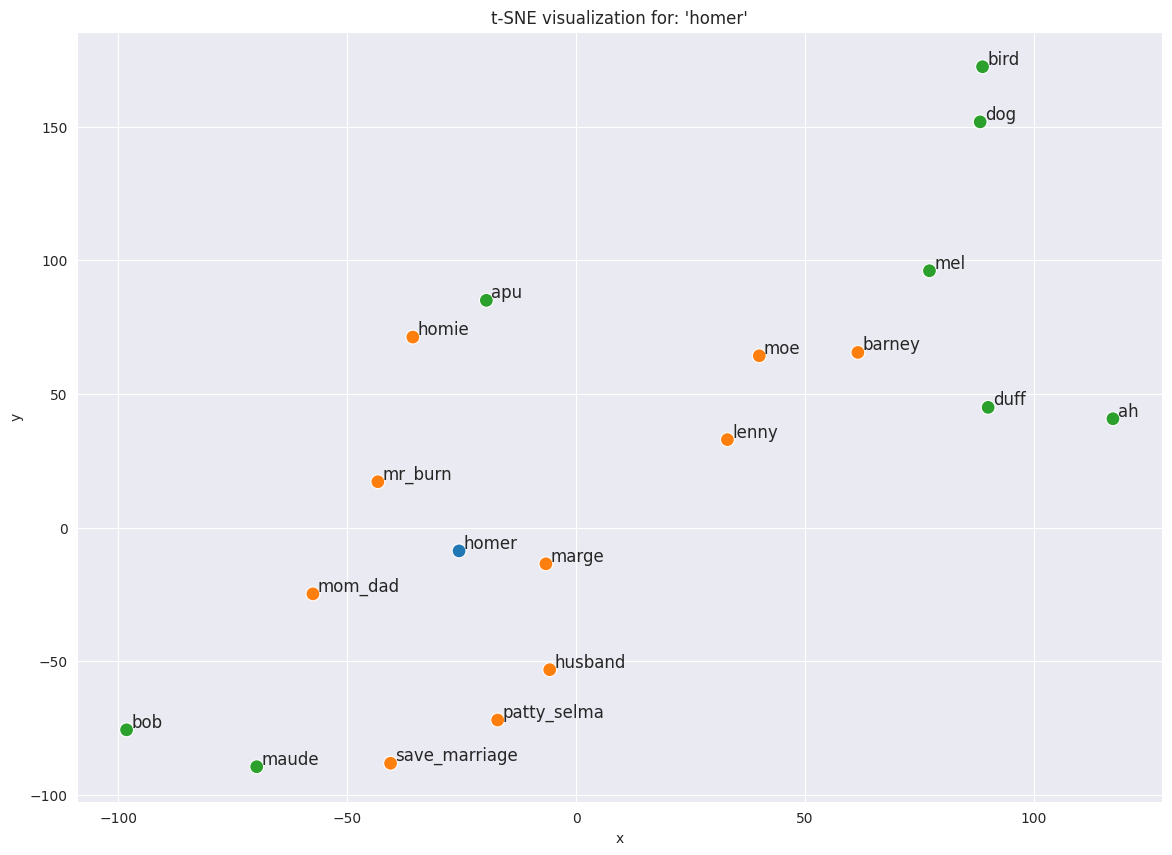

In [59]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])